In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.utils as skl
from scipy.special import expit
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        # Inicialização dos pesos e bias
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Camada oculta
        self.hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.tanh(self.hidden_layer_input)

        # Camada de saída
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = self.softmax(self.output_layer_input)

        return self.output_layer_output

    def backward(self, X, y, learning_rate):
        # Calcula o erro
        output_error = y - self.output_layer_output

        # Atualiza os pesos da camada de saída
        output_delta = output_error * self.softmax_derivative(self.output_layer_output)
        self.weights_hidden_output += np.dot(self.hidden_layer_output.T, output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate

        # Calcula o erro na camada oculta
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)

        # Atualiza os pesos da camada oculta
        hidden_delta = hidden_error * self.tanh_derivative(self.hidden_layer_output)
        self.weights_input_hidden += np.dot(X.T, hidden_delta) * learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    def calculate_metrics(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        total = len(y_true)

        accuracy = (correct / total)*100

        true_positive = np.sum((y_true == 1) & (y_pred == 1))
        false_positive = np.sum((y_true == 0) & (y_pred == 1))
        false_negative = np.sum((y_true == 1) & (y_pred == 0))

        precision = (true_positive / (true_positive + false_positive))*100 if (true_positive + false_positive) != 0 else 0
        recall = (true_positive / (true_positive + false_negative))*100 if (true_positive + false_negative) != 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        return accuracy, precision, recall, f1

    def train(self, X, y, epochs, learning_rate):
        # Converta y para um array 2D se necessário
        if isinstance(y, pd.Series):
            y = pd.get_dummies(y).values

        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)

            # Backward pass
            self.backward(X, y, learning_rate)

            # Calcula as métricas de avaliação
            y_pred = np.argmax(output, axis=1)
            y_true = np.argmax(y, axis=1)
            acuracia, precisao, recall, f1 = self.calculate_metrics(y_true, y_pred)

            # Mostra as métricas a cada 10 epochs
            if epoch % 10 == 0:
                loss = -np.sum(y * np.log(output + 1e-8))  # constante para evitar log(0)
                print(f'\nÉpoca {epoch}, \nLoss: {loss}, \nAcurácia: {acuracia}, \nPrecisão: {precisao}, \nRecall: {recall}, \nF1-Score: {f1}\n')

    def predict(self, X):
        # Camada oculta
        hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        hidden_layer_output = self.tanh(hidden_layer_input)

        # Camada de saída
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output) + self.bias_output
        output_layer_output = self.softmax(output_layer_input)

        return output_layer_output


    def evaluate(self, X_test, y_test):
        if isinstance(y_test, pd.Series):
            y_test = pd.get_dummies(y_test).values

        # Faça previsões nos dados de teste
        predictions = self.predict(X_test)

        # Calcula as métricas de avaliação
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy, precision, recall, f1 = self.calculate_metrics(y_true, y_pred)

        print(f'Acurácia: {accuracy}, \nPrecisão: {precision}, \nRecall: {recall}, \nF1-Score: {f1}')

        # Plota a matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'])
        plt.title('Matriz de Confusão')
        plt.xlabel('Previsão')
        plt.ylabel('Verdadeiro')
        plt.show()


    def plot_decision_boundary(self, X, y):
        # Definir os limites do gráfico
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        # Gerar grade de pontos
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                np.arange(y_min, y_max, 0.1))

        # Previsões para cada ponto na grade
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)

        # Plotar a superfície de decisão
        plt.contourf(xx, yy, Z, alpha=0.8)

        # Plotar os pontos de dados
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel('Lightness')
        plt.ylabel('Width')
        plt.title('Superfície de Decisão')
        plt.legend(loc='upper right')
        plt.show()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Trabalhos Deep Learning/MLP/salmon_seabass.csv')

In [ ]:
data

,index,lightness,width,species
0,0,2.834754,21.087143,0
1,1,3.329180,18.877143,0
2,2,3.690492,19.824286,0
3,3,4.812459,17.760000,0
4,4,4.812459,16.497143,0
...,...,...,...,...
126,126,8.976774,18.656940,1
127,127,5.365806,21.308897,1
128,128,6.226452,20.203915,1
129,129,8.789677,16.054093,1


# Verificando dados inconsistentes

In [ ]:
data.loc[data['lightness'] < 0]

,index,lightness,width,species


In [ ]:
data.loc[data['width'] < 0]

,index,lightness,width,species


In [ ]:
data.loc[data['species'] > 1]

,index,lightness,width,species


# Verificando tipo dos dados

In [ ]:
data.dtypes

index          int64
lightness    float64
width        float64
species        int64
dtype: object

# Verificando Valores Faltantes

In [ ]:
data.isnull().sum()

index        0
lightness    0
width        0
species      0
dtype: int64

# Verificando se há desbalanceamento entre as classes

In [ ]:
import plotly.express as px
px.pie(data,names='species',title='Proporção de especies',hole=0.33)

# Realizando Divisão entre X e Y, logo após fazendo a divisão entre treino e teste

In [ ]:
X = data[['lightness', 'width']]
Y = data['species']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

# Realizando Treinamento da rede

In [ ]:
# Inicializa a MLP
# 2 neuronios de entrada
# uma camada oculta com 8 neurônios
# camada de saída com dois neurônios

mlp = MLP(2, 8, 2)

# Treino da rede
mlp.train(X_train, Y_train, epochs=100, learning_rate=0.001)


Época 0, 
Loss: 119.43199555521262, 
Acurácia: 45.19230769230769, 
Precisão: 45.19230769230769, 
Recall: 100.0, 
F1-Score: 62.25165562913908


Época 10, 
Loss: 80.325290096553, 
Acurácia: 45.19230769230769, 
Precisão: 45.19230769230769, 
Recall: 100.0, 
F1-Score: 62.25165562913908


Época 20, 
Loss: 57.466898089303484, 
Acurácia: 76.92307692307693, 
Precisão: 66.19718309859155, 
Recall: 100.0, 
F1-Score: 79.66101694915254


Época 30, 
Loss: 49.52677163441593, 
Acurácia: 83.65384615384616, 
Precisão: 75.0, 
Recall: 95.74468085106383, 
F1-Score: 84.11214953271028


Época 40, 
Loss: 45.59887958229507, 
Acurácia: 85.57692307692307, 
Precisão: 79.62962962962963, 
Recall: 91.48936170212765, 
F1-Score: 85.14851485148515


Época 50, 
Loss: 43.44693433622673, 
Acurácia: 85.57692307692307, 
Precisão: 79.62962962962963, 
Recall: 91.48936170212765, 
F1-Score: 85.14851485148515


Época 60, 
Loss: 41.893551104957766, 
Acurácia: 85.57692307692307, 
Precisão: 79.62962962962963, 
Recall: 91.4893617021

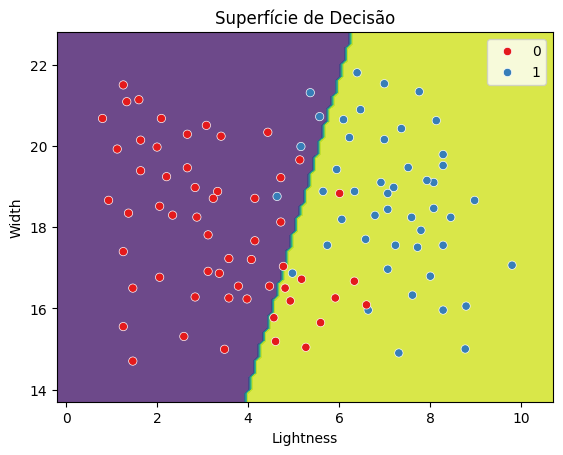

In [ ]:
# plota a superfície de decisão nos dados de treino
mlp.plot_decision_boundary(X_train.values, Y_train.values)

# Teste com a rede MLP

Acurácia: 85.18518518518519, 
Precisão: 87.5, 
Recall: 70.0, 
F1-Score: 77.77777777777777


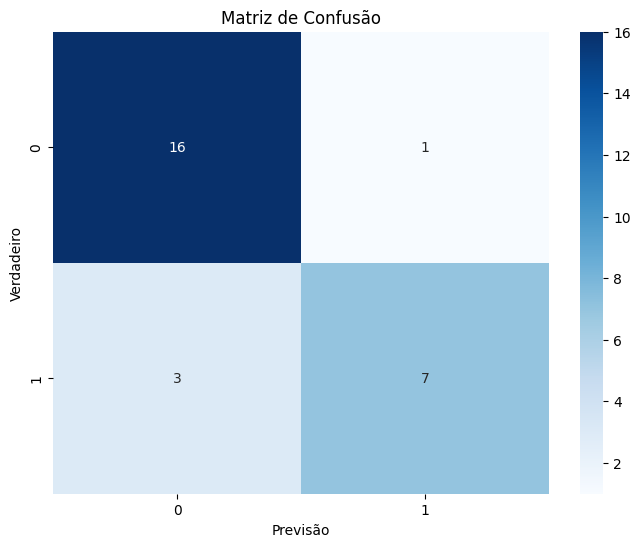

In [ ]:
y_pred = mlp.evaluate(X_test, Y_test)

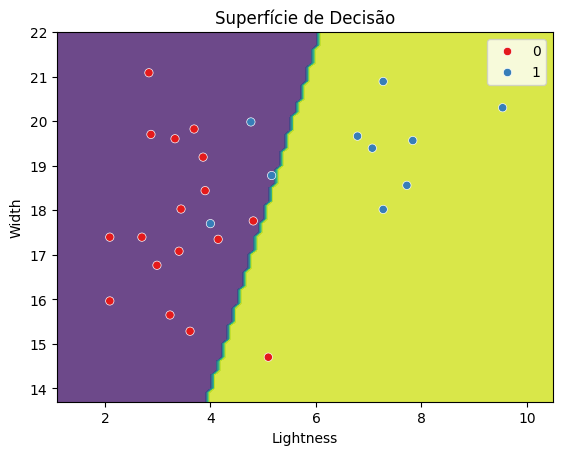

In [ ]:
# plota a superfície de decisão nos dados de treino
mlp.plot_decision_boundary(X_test.values, Y_test.values)

# Testando com balanceamento de Classes

In [ ]:
import plotly.express as px
px.pie(data,names='species',title='Proporção de especies',hole=0.33)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

In [ ]:
import plotly.express as px
px.pie(Y_train,names='species',title='Proporção de especies',hole=0.33)

In [ ]:
# Inicializa a MLP
# 2 neuronios de entrada
# uma camada oculta com 8 neurônios
# camada de saída com dois neurônios

mlp = MLP(2, 8, 2)

# Treino da rede
mlp.train(X_train, Y_train, epochs=100, learning_rate=0.001)


Época 0, 
Loss: 92.54198733517906, 
Acurácia: 45.614035087719294, 
Precisão: 47.706422018348626, 
Recall: 91.22807017543859, 
F1-Score: 62.65060240963855


Época 10, 
Loss: 73.57442845597191, 
Acurácia: 72.80701754385966, 
Precisão: 66.66666666666666, 
Recall: 91.22807017543859, 
F1-Score: 77.03703703703701


Época 20, 
Loss: 63.55152469908539, 
Acurácia: 82.45614035087719, 
Precisão: 74.02597402597402, 
Recall: 100.0, 
F1-Score: 85.07462686567163


Época 30, 
Loss: 56.4889197581889, 
Acurácia: 85.96491228070175, 
Precisão: 78.87323943661971, 
Recall: 98.24561403508771, 
F1-Score: 87.49999999999999


Época 40, 
Loss: 50.23585280757304, 
Acurácia: 85.08771929824562, 
Precisão: 78.57142857142857, 
Recall: 96.49122807017544, 
F1-Score: 86.61417322834646


Época 50, 
Loss: 45.28025966672192, 
Acurácia: 85.96491228070175, 
Precisão: 80.59701492537313, 
Recall: 94.73684210526315, 
F1-Score: 87.09677419354837


Época 60, 
Loss: 42.391784401676084, 
Acurácia: 85.96491228070175, 
Precisão: 81.

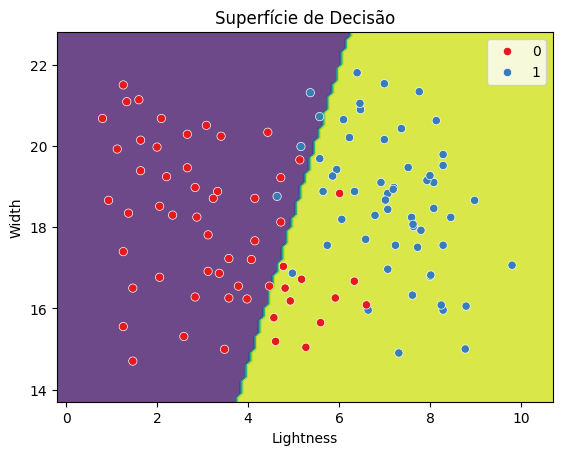

In [ ]:
# plota a superfície de decisão nos dados de treino
mlp.plot_decision_boundary(X_train.values, Y_train.values)

Acurácia: 88.88888888888889, 
Precisão: 88.88888888888889, 
Recall: 80.0, 
F1-Score: 84.21052631578948


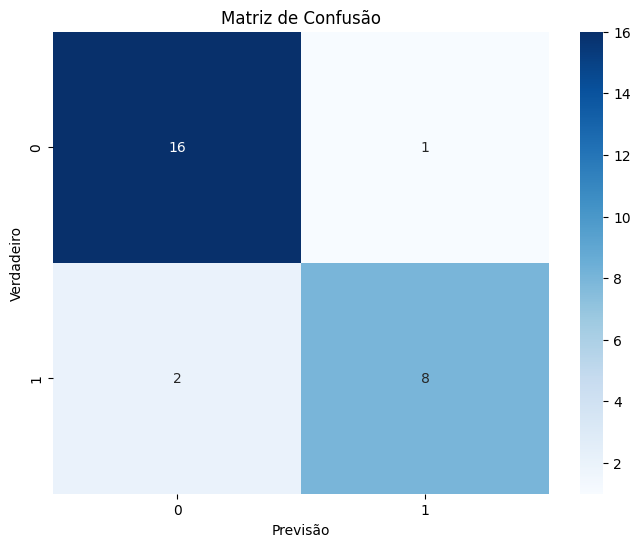

In [ ]:
y_pred = mlp.evaluate(X_test, Y_test)

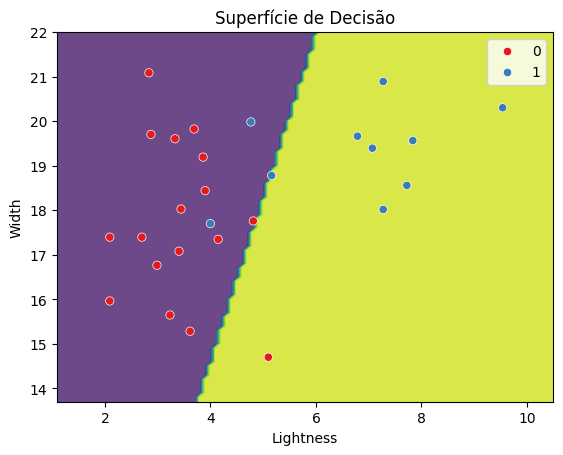

In [ ]:
# plota a superfície de decisão nos dados de treino
mlp.plot_decision_boundary(X_test.values, Y_test.values)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=39):
        super(CustomCNN, self).__init__()
        # Camada de convolução 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Camada de convolução 2
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Camada de convolução 3
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(8 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Aplicação das camadas convolucionais e de pooling
        x = self.pool1(F.relu(self.conv1(x)))  # Convolução + ReLU + Pooling
        x = self.pool2(F.relu(self.conv2(x)))  # Convolução + ReLU + Pooling
        x = self.pool3(F.relu(self.conv3(x)))  # Convolução + ReLU + Pooling

        # Flatten das saídas
        x = x.view(-1, 8 * 28 * 28)

        # Aplicação das camadas totalmente conectadas
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Exemplo de uso
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=39)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total de Parâmetros: {count_parameters(model):,}")


Total de Parâmetros: 814,655
